In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os 
import timeit
import math
import time
import sparse
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
from glob import glob
from os import path
from tqdm import tqdm

from ll_Balltree import *
%run -i 'll_Balltree.py'

In [2]:
outputDir = 'data/posterior_computation_data/'
gom_masks = xr.open_dataset(outputDir + 'cell_masks.nc')

# GLOBAL CONSTANTS
MIN_LON = np.min(gom_masks['lon'].values)
MAX_LON = np.max(gom_masks['lon'].values)
MIN_LAT = np.min(gom_masks['lat'].values)
MAX_LAT = np.max(gom_masks['lat'].values)

#domain width and height (cell counts)
LAT_SIZE = gom_masks.dims['lat']
LON_SIZE = gom_masks.dims['lon']

#cell size
D_LON = gom_masks["lon"][1].values - gom_masks["lon"][0].values
D_LAT = gom_masks["lat"][1].values - gom_masks["lat"][0].values

BIN_CELL_LATS = gom_masks.bin_cell_lats.values
BIN_CELL_LONS = gom_masks.bin_cell_lons.values

MIN_LON, MAX_LON, MIN_LAT, MAX_LAT,LAT_SIZE,LON_SIZE, D_LON,D_LAT

(-97.98001098632812,
 -76.45999145507812,
 18.140000343322754,
 31.899998664855957,
 345,
 539,
 0.03997802734375,
 0.03999900817871094)

Window Indexing Scheme

In [3]:
inputDir_Sim = ('data/output_v2/rechunked/')
inputFiles_Sim = sorted(glob(inputDir_Sim + '*.zarr' ))

beaching_windows = pd.to_datetime(np.arange('2019-07', '2022-01', dtype='datetime64[M]'))
source_windows = pd.to_datetime(np.arange('2019-01', '2022-01', dtype='datetime64[M]'))

# number of beaching windows
n_window_beaching =  len(beaching_windows) 

# number of source windows
n_window_source =  len(source_windows)     

d = (n_window_source - n_window_beaching) 
# particles tracked for n days = m months,so we need (m) additional months from the last possible beaching months

beaching_ym_idx = np.append([-(n_window_source +1)]*(d), np.arange(n_window_beaching)) 
                                                                                         
beaching_ym_mat = np.reshape(beaching_ym_idx, (3,12))
# Matrix used to index beaching (year,month), to the corresponding beaching_windows value

source_ym_idx = np.arange(n_window_source)
source_ym_mat = np.reshape(source_ym_idx, (3,12))
# Matrix used to index source (year,month), to the corresponding source_windows value

Nurdle Indexing Scheme

In [4]:
# CREATE COAST CELL TREE
idx_coast_mask = np.where(gom_masks.coastalmask == 1)
coast_cells = get_cells(idx_mask = idx_coast_mask, 
                            lats = gom_masks['lat'].values,
                            lons = gom_masks['lon'].values)
coast_cell_tree = build_ll_BallTree(coast_cells)

# LOAD NURDLE DATA AS DONE IN THE SIMULATION
df_all_nurdles = pd.read_csv('data/input/' + 'nurdle_release.csv')
df_all_nurdles['patrol_date'] = pd.to_datetime(df_all_nurdles['patrol_date'])
df_all_nurdles.iloc[df_all_nurdles[df_all_nurdles.nurdle_count > 10000].index, 4] = 10000 

n_total_nurdles = np.sum(df_all_nurdles.nurdle_count)

print("Number of Nurdles: ", n_total_nurdles)

nurdle_cells = get_cells(idx_mask = None, lats = df_all_nurdles.lat.values, lons = df_all_nurdles.lon.values)
_, nurdle_ind = query_ll_BallTree(tree = coast_cell_tree, cells = nurdle_cells)

nf = {'nurdle_ind': nurdle_ind, 'lat': coast_cells[0][nurdle_ind], 'lon': coast_cells[1][nurdle_ind], 
      'nurdle_count': df_all_nurdles.nurdle_count, 'patrol_date': df_all_nurdles.patrol_date, }
df_all_nurdles = pd.DataFrame(data=nf).sort_values(by='patrol_date')

nurdle_count_idx = df_all_nurdles.groupby('nurdle_ind').nurdle_count.sum().reset_index()

nurdle_count_map = np.zeros((LAT_SIZE, LON_SIZE))
idx_nurdle_count_lats = idx_coast_mask[0][nurdle_count_idx.nurdle_ind]
idx_nurdle_count_lons = idx_coast_mask[1][nurdle_count_idx.nurdle_ind]

nurdle_count_map[idx_nurdle_count_lats, idx_nurdle_count_lons] = nurdle_count_idx.nurdle_count

# Assign to cell mask
gom_masks = gom_masks.assign(nurdlecount = (('lat', 'lon'), nurdle_count_map))

Number of Nurdles:  444145


In [10]:
np.mean(df_all_nurdles.groupby(df_all_nurdles.patrol_date.dt.day).nurdle_count.mean())

181.60901748131016

In [5]:
# BEACHING CELL TREE
beaching_cells_idx = np.where(gom_masks.nurdlecount > 0.0)
beaching_cells = get_cells(beaching_cells_idx, lats = gom_masks['lat'].values,
                                               lons = gom_masks['lon'].values)
beaching_cell_tree = build_ll_BallTree(beaching_cells)

n_cell_beaching = np.shape(beaching_cells_idx)[1]

Data Mine - Particle Count Matrix and Source Cells

In [6]:
particle_count = np.zeros((n_cell_beaching,n_window_beaching))
source_cell_hist = np.histogram2d([], [], bins=(BIN_CELL_LONS, BIN_CELL_LATS))[0]

# Trajectories are stored in 5 seperate files 
for filename in inputFiles_Sim:

    print("Processing: " + filename)

    df = xr.open_zarr(filename).dropna(dim="trajectory", how="all")

    print("df shape: " + str(df.dims))

    time_raw = pd.DatetimeIndex(df['time'].values)
    x_raw = df['lon'].values
    y_raw = df['lat'].values

    # GET PARTICLE BEACHING CELL INDEX
    beaching_cell_query = get_cells(None, y_raw[:, 0], x_raw[:, 0])
    _, cell_beaching_inds = query_ll_BallTree(tree = beaching_cell_tree, cells = beaching_cell_query)

    # COMPUTE BIN COUNTS
    for i in tqdm(range(len(x_raw)), desc = "Compute Bin Counts"):
        # Get beaching window
        beaching_time = time_raw[i][0]
        beaching_window = beaching_ym_mat[beaching_time.year - 2019, beaching_time.month - 1]

        #Get beaching location
        beaching_cell = cell_beaching_inds[i]

        # Add beaching location to counts
        particle_count[beaching_cell, beaching_window] += 1

        # Aggregate only the source cells visited
        source_cell_hist += np.histogram2d(x_raw[i, 1:], y_raw[i, 1:], bins=(BIN_CELL_LONS, BIN_CELL_LATS))[0]

source_cell_hist = source_cell_hist.T

Processing: data/output_v2/rechunked/GOM_rt_2019_12.0-7.0_at_180.0.zarr
df shape: Frozen({'trajectory': 103173, 'obs': 182})


Compute Bin Counts: 100%|██████████| 103173/103173 [01:23<00:00, 1232.78it/s]


Processing: data/output_v2/rechunked/GOM_rt_2020_12.0-7.0_at_180.0.zarr
df shape: Frozen({'trajectory': 116025, 'obs': 182})


Compute Bin Counts: 100%|██████████| 116025/116025 [01:27<00:00, 1325.27it/s]


Processing: data/output_v2/rechunked/GOM_rt_2020_6.0-1.0_at_180.0.zarr
df shape: Frozen({'trajectory': 44915, 'obs': 182})


Compute Bin Counts: 100%|██████████| 44915/44915 [00:34<00:00, 1315.29it/s]


Processing: data/output_v2/rechunked/GOM_rt_2021_12.0-7.0_at_180.0.zarr
df shape: Frozen({'trajectory': 23475, 'obs': 182})


Compute Bin Counts: 100%|██████████| 23475/23475 [00:18<00:00, 1244.31it/s]


Processing: data/output_v2/rechunked/GOM_rt_2021_6.0-1.0_at_180.0.zarr
df shape: Frozen({'trajectory': 61589, 'obs': 182})


Compute Bin Counts: 100%|██████████| 61589/61589 [00:48<00:00, 1262.83it/s]


Domain Cell Indexing Scheme

In [7]:
# Find all non zero cells
source_cell_mask = np.where(source_cell_hist > 0.0)

# Get the number of domain cells
_, n_cell_source = np.shape(source_cell_mask)
print("Number of Source Cells: ", n_cell_source)

# Create a mask of for domain cells
source_cells_map = np.zeros(np.shape(source_cell_hist))
source_cells_map[source_cell_mask] = 1.0

# Label Source Cells
source_cells_map_idx = (gom_masks.landmask + 2*gom_masks.coastalmask + 3*gom_masks.oceanmask)*source_cells_map

# If Source Cell is not 2 or 3 then it unlabeled
unlabeled_cells = (source_cells_map_idx == 1).astype(int)

# Reassign masks to include the unlabeled domain cells
gom_masks['landmask']= (('lat', 'lon'), (gom_masks.landmask.values - unlabeled_cells.values))
gom_masks['coastalmask'] = (('lat', 'lon'), (gom_masks.coastalmask.values + unlabeled_cells.values))

# Create a labeled mask for reverse indexing (testing purposes)
source_cells_idx_map = np.zeros(np.shape(source_cell_hist))*np.nan
source_cells_idx_map[source_cell_mask] =  np.arange(0, n_cell_source)

# Build Source Cell Tree
source_cells = get_cells(idx_mask = source_cell_mask, lats =  gom_masks['lat'].values, lons = gom_masks['lon'].values)
source_cell_tree = build_ll_BallTree(source_cells)

# Add Source Cell Masks to Corrected Domain
gom_masks = gom_masks.assign(source_cell_hist  = (('lat', 'lon'), source_cell_hist ))
gom_masks = gom_masks.assign(source_cells_map = (('lat', 'lon'), source_cells_map))


Number of Source Cells:  114024


/home/dpojunas/.conda/envs/py3_parcels/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


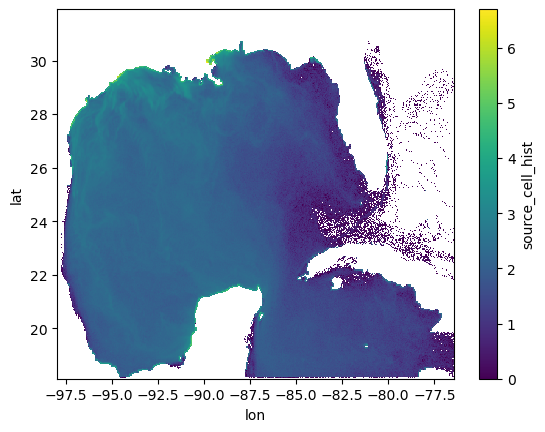

In [8]:
# Display Summed Trajectories
np.log10(gom_masks.source_cell_hist).plot()

Save Data

In [9]:
output = {}
output['n_cell_beaching'] = n_cell_beaching
output['n_cell_source'] = n_cell_source
output['n_window_beaching'] = n_window_beaching
output['n_window_source'] = n_window_source

output['particle_count'] = particle_count

output['beaching_cells'] = beaching_cells
output['beaching_cell_tree'] = beaching_cell_tree

output['source_cell_mask'] = source_cell_mask
output['source_cells'] = source_cells
output['source_cell_tree'] = source_cell_tree

output['beaching_windows'] = beaching_windows 
output['source_windows'] = source_windows
output['d'] = d 
output['beaching_ym_mat'] = beaching_ym_mat
output['source_ym_mat'] = source_ym_mat

In [10]:
import pickle

outputDir = 'data/posterior_computation_data/'

# Save domain_cell_tree
fileObj_output = open(outputDir + 'output_dict.obj', 'wb')
pickle.dump(output,fileObj_output)
fileObj_output.close()

In [11]:
gom_masks.to_netcdf(outputDir +'domain_cell_masks.nc')

Test Data

In [12]:
# Tests
#
windows_ym_mat = np.reshape(source_windows,(3,12))
# (CHECK) Matrix used to index any (year,month) index, to the corresponding source_windows values
print(windows_ym_mat)
#
for i in range(n_window_beaching):
    test_beaching_window = beaching_windows[i]
    assert(beaching_ym_mat[test_beaching_window.year - 2019, test_beaching_window.month - 1] == i)
    assert(windows_ym_mat[test_beaching_window.year - 2019, test_beaching_window.month - 1] == test_beaching_window)
    
for i in range(n_window_source):
    test_source_window = source_windows[i]
    assert(source_ym_mat[test_source_window.year - 2019, test_source_window.month - 1] == i)
    assert(windows_ym_mat[test_source_window.year - 2019, test_source_window.month - 1] == test_source_window)
# (CHECK) This tests that each index in the source and beaching times correspond with each matrix

[['2019-01-01T00:00:00' '2019-02-01T00:00:00' '2019-03-01T00:00:00'
  '2019-04-01T00:00:00' '2019-05-01T00:00:00' '2019-06-01T00:00:00'
  '2019-07-01T00:00:00' '2019-08-01T00:00:00' '2019-09-01T00:00:00'
  '2019-10-01T00:00:00' '2019-11-01T00:00:00' '2019-12-01T00:00:00']
 ['2020-01-01T00:00:00' '2020-02-01T00:00:00' '2020-03-01T00:00:00'
  '2020-04-01T00:00:00' '2020-05-01T00:00:00' '2020-06-01T00:00:00'
  '2020-07-01T00:00:00' '2020-08-01T00:00:00' '2020-09-01T00:00:00'
  '2020-10-01T00:00:00' '2020-11-01T00:00:00' '2020-12-01T00:00:00']
 ['2021-01-01T00:00:00' '2021-02-01T00:00:00' '2021-03-01T00:00:00'
  '2021-04-01T00:00:00' '2021-05-01T00:00:00' '2021-06-01T00:00:00'
  '2021-07-01T00:00:00' '2021-08-01T00:00:00' '2021-09-01T00:00:00'
  '2021-10-01T00:00:00' '2021-11-01T00:00:00' '2021-12-01T00:00:00']]
